# Logistics Analysis

In this example, we will analyze the accuracy of a public transit system. The example, is analyzing three lines in Seattle, and it is based on the great blog post [The Waiting Time Paradox, or, Why Is My Bus Always Late?](https://jakevdp.github.io/blog/2018/09/13/waiting-time-paradox/)

In [51]:
import pandas as pd
import numpy as np

## Loading the data

In [6]:
from IPython.display import Image
Image(url='http://jakevdp.github.io/images/seattle-transit-map.png') 

In [1]:
url = 'https://gist.githubusercontent.com/jakevdp/82409002fcc5142a2add0168c274a869/raw/1bbabf78333306dbc45b9f33662500957b2b6dc3/arrival_times.csv'

import requests
from io import StringIO

response = requests.get(url)
response

<Response [200]>

The CSV file is read through a URL and therefore, we need to convert the text of the response to a simple string as we get when we read a local file. For that we will use the StringIO functionality as follows:

In [4]:
bus_arrival_times = (
    pd
    .read_csv(
        StringIO(
            response.text
        )
    )
)

bus_arrival_times

,OPD_DATE,VEHICLE_ID,RTE,DIR,TRIP_ID,STOP_ID,STOP_NAME,SCH_STOP_TM,ACT_STOP_TM
0,2016-03-26,6201,673,S,30908177,431,3RD AVE & PIKE ST (431),01:11:57,01:13:19
1,2016-03-26,6201,673,S,30908033,431,3RD AVE & PIKE ST (431),23:19:57,23:16:13
2,2016-03-26,6201,673,S,30908028,431,3RD AVE & PIKE ST (431),21:19:57,21:18:46
3,2016-03-26,6201,673,S,30908019,431,3RD AVE & PIKE ST (431),19:04:57,19:01:49
4,2016-03-26,6201,673,S,30908252,431,3RD AVE & PIKE ST (431),16:42:57,16:42:39
...,...,...,...,...,...,...,...,...,...
39152,2016-05-27,6215,674,N,30905957,578,3RD AVE & PIKE ST (578),10:50:25,10:49:50
39153,2016-05-27,6215,674,N,30905720,578,3RD AVE & PIKE ST (578),13:02:27,13:07:10
39154,2016-05-27,6215,674,N,30905729,578,3RD AVE & PIKE ST (578),15:14:29,15:15:55
39155,2016-05-27,6215,674,N,30905740,578,3RD AVE & PIKE ST (578),17:26:29,17:25:40


## Data Exploration

Let's check how many days, buses, routes, trips, stops, etc. do we have in the data.
* Start with the bus arrival times data above
* Convert every cell to string value
* Describe the table (count, unique values, top and frequency)
* Focus only on the unique values count

In [21]:
(
    bus_arrival_times
    .astype(str)
    .describe()
    .loc['unique']
)

OPD_DATE          63
VEHICLE_ID       115
RTE                3
DIR                2
TRIP_ID         1660
STOP_ID            2
STOP_NAME          2
SCH_STOP_TM     1357
ACT_STOP_TM    27633
Name: unique, dtype: object

We see that we have 63 days of data, for 115 buses, in 3 lines (_RTE_) and 2 directions and schedule and arrival times in 2 stops over 1660 trips.

## Data Cleanup

Let's make the data easier to understand and to calculate the accuracy of the lines
* Start with the bus arrival times table above
* Create a _scheduled_ column timestamp with the combination of the date and the scheduled stop time
* Create a _actual_ column timestamp with the combination of the date and the actual stop time
* Calculate the difference between the above timestamps 
* Calculate the difference in minutes by scaling to seconds and then 60 (seconds in a minute)
* Fix the rows that fall across midnights (difference larger than 1000 minutes)
* Add a column with the route symbol (_C_, _D_ or _E_)
* Add a column with the direction of the trip (_northbound_ or _southbound_)
* Focus only on the new columns we created here

In [63]:
trips_accuracy = (
    bus_arrival_times
    .assign(scheduled = lambda x : pd.to_datetime(x.OPD_DATE + ' ' + x.SCH_STOP_TM))
    .assign(actual = lambda x : pd.to_datetime(x.OPD_DATE + ' ' + x.ACT_STOP_TM))
    .assign(
        time_diff = lambda x : (x.actual - x.scheduled)
    )
    .assign(
        minutes_late = lambda x : x.time_diff.dt.total_seconds() / 60
    )
    .assign(minutes_late = lambda x: np.where(
        x.minutes_late < 1000, 
        x.minutes_late, 
        x.minutes_late - 60*24)
    )
    .assign(minutes_late = lambda x: np.where(
        x.minutes_late > -1000, 
        x.minutes_late, 
        x.minutes_late + 60*24)
    )
    .assign(route = lambda x: x.RTE.replace({
        673: 'C', 
        674: 'D', 
        675: 'E'})
        .astype('category')
    )
    .assign(direction = lambda x :x.DIR.replace({
        'N': 'northbound', 
        'S': 'southbound'})
        .astype('category')
    )
    .loc[:,['route', 'direction', 'scheduled', 'actual', 'minutes_late']]
)
trips_accuracy

,route,direction,scheduled,actual,minutes_late
0,C,southbound,2016-03-26 01:11:57,2016-03-26 01:13:19,1.366667
1,C,southbound,2016-03-26 23:19:57,2016-03-26 23:16:13,-3.733333
2,C,southbound,2016-03-26 21:19:57,2016-03-26 21:18:46,-1.183333
3,C,southbound,2016-03-26 19:04:57,2016-03-26 19:01:49,-3.133333
4,C,southbound,2016-03-26 16:42:57,2016-03-26 16:42:39,-0.300000
...,...,...,...,...,...
39152,D,northbound,2016-05-27 10:50:25,2016-05-27 10:49:50,-0.583333
39153,D,northbound,2016-05-27 13:02:27,2016-05-27 13:07:10,4.716667
39154,D,northbound,2016-05-27 15:14:29,2016-05-27 15:15:55,1.433333
39155,D,northbound,2016-05-27 17:26:29,2016-05-27 17:25:40,-0.816667


### Accuracy Histogram

We can quickly graph the distribution of the accuracy

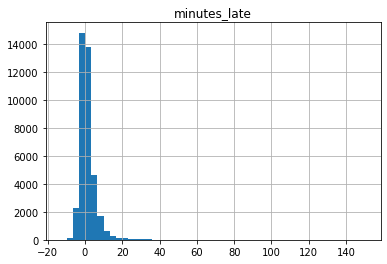

In [79]:
(
    trips_accuracy
    .hist(bins=50)
);

Or even break it down by the different routes and directions to see if the grouops are behaving in a similar way

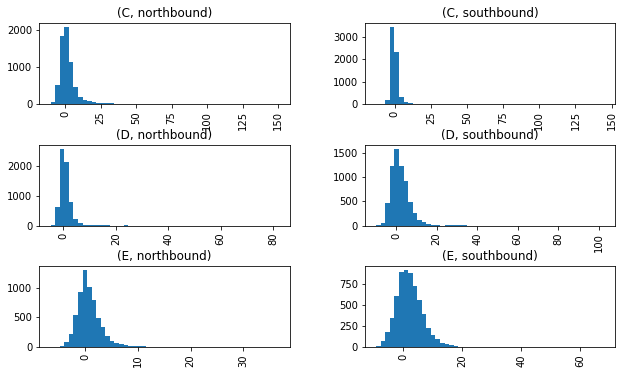

In [82]:
(
    trips_accuracy
    .hist(
        bins=50 , 
        by=['route','direction'], 
        figsize=(10,6)
    )
);

### Fancier Visualization

The default visualization functionality of Pandas is often enhanced with a set of graphic libraries that we will cover in a dedicated chapter. Here is an improved visualization using Seaborn.

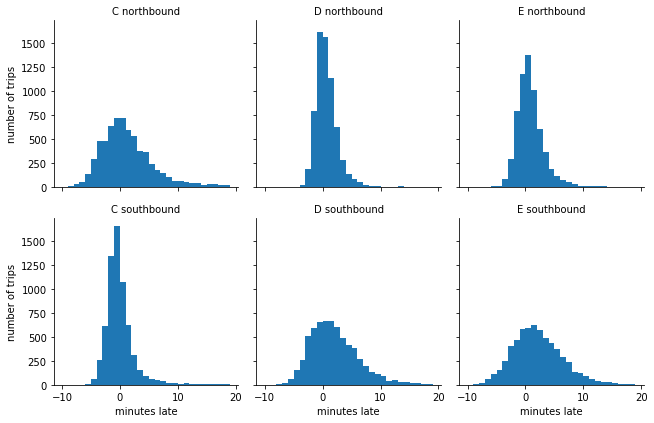

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
g = (
    sns
    .FacetGrid(
        trips_accuracy, 
        row="direction", 
        col="route"
    )

g.map(
    plt.hist, 
    "minutes_late", 
    bins=np.arange(-10, 20)
)
g.set_titles('{col_name} {row_name}')
g.set_axis_labels('minutes late', 'number of trips');